In [21]:
# Import numpy+extensions, i/o functions, preprocessing, and visualization.
import numpy as numx
import pydeep.base.numpyextension as numxext
import pydeep.misc.io as io
import pydeep.preprocessing as pre
import pydeep.misc.visualization as vis

# Model imports: RBM estimator, model and trainer module
import pydeep.rbm.estimator as estimator
import pydeep.rbm.model as model
import pydeep.rbm.trainer as trainer

import numpy as np
import torch
import matplotlib.pyplot as plt

In [22]:
# Set random seed (optional)
# (optional, if stochastic processes are involved we get the same results)
numx.random.seed(42)

In [29]:
training_data_size = 10000
group_size = training_data_size//2
data_size = 100
data = []
data = np.zeros((training_data_size,data_size))
data[:group_size,:] = np.random.uniform(size =(group_size,data_size))
data[group_size:,:] = np.random.normal(loc = 0.5, size =(group_size,data_size))
data = np.random.permutation(data)
#data = torch.FloatTensor(training_set)
#data = training_set
#print(np.shape(data))

In [30]:
# Set input/output dimensions
v1 = 100
v2 = 1
h1 = 2
h2 = 1

# Whiten data using ZCA
zca = pre.ZCA(v1 * v2)
zca.train(data)
data = zca.project(data)

In [31]:
# Split into training/test data
train_data = data[0:5000]
test_data = data[5000:10000]

# Set restriction factor, learning rate, batch size and maximal number of epochs
restrict = 0.01 * numx.max(numxext.get_norms(train_data, axis=1))
eps = 0.1
batch_size = 100
max_epochs = 200

In [32]:
# Create model, initial weights=Glorot init., initial sigma=1.0, initial bias=0,
# no centering (Usually pass the data=training_data for a automatic init. that is
# set the bias and sigma to the data mean and data std. respectively, for
# whitened data centering is not an advantage)
rbm = model.GaussianBinaryVarianceRBM(number_visibles=v1 * v2,
                                      number_hiddens=h1 * h2,
                                      initial_weights='AUTO',
                                      initial_visible_bias=0,
                                      initial_hidden_bias=0,
                                      initial_sigma=1.0,
                                      initial_visible_offsets=0.0,
                                      initial_hidden_offsets=0.0,
                                      dtype=numx.float64)

# Set the hidden bias such that the scaling factor is 0.01
rbm.bh = -(numxext.get_norms(rbm.w + rbm.bv.T, axis=0) - numxext.get_norms(
    rbm.bv, axis=None)) / 2.0 + numx.log(0.01)
rbm.bh = rbm.bh.reshape(1, h1 * h2)

In [33]:
# Training with CD-1
k = 1
trainer_cd = trainer.CD(rbm)

# Train model, status every 10th epoch
step = 10
print('Training')
print('Epoch\tRE train\tRE test')
for epoch in range(0, max_epochs + 1, 1):

    # Shuffle training samples (optional)
    train_data = numx.random.permutation(train_data)

    # Print epoch and reconstruction errors every 'step' epochs.
    if epoch % step == 0:
        RE_train = numx.mean(estimator.reconstruction_error(rbm, train_data))
        RE_test = numx.mean(estimator.reconstruction_error(rbm, test_data))
        print('%5d \t%0.5f \t%0.5f' % (epoch, RE_train, RE_test))

    # Train one epoch with gradient restriction/clamping
    # No weight decay, momentum or sparseness is used
    for b in range(0, train_data.shape[0], batch_size):
        trainer_cd.train(data=train_data[b:(b + batch_size), :],
                         num_epochs=1,
                         epsilon=[eps, 0.0, eps, eps * 0.1],
                         k=k,
                         momentum=0.0,
                         reg_l1norm=0.0,
                         reg_l2norm=0.0,
                         reg_sparseness=0,
                         desired_sparseness=None,
                         update_visible_offsets=0.0,
                         update_hidden_offsets=0.0,
                         offset_typ='00',
                         restrict_gradient=restrict,
                         restriction_norm='Cols',
                         use_hidden_states=False,
                         use_centered_gradient=False)


Training
Epoch	RE train	RE test
    0 	1.00652 	0.99089
   10 	1.00356 	0.98910
   20 	1.00138 	0.98810
   30 	1.00057 	0.98797
   40 	1.00006 	0.98790
   50 	0.99982 	0.98784
   60 	0.99971 	0.98788
   70 	0.99955 	0.98795
   80 	0.99936 	0.98794
   90 	0.99935 	0.98820
  100 	0.99936 	0.98832
  110 	0.99929 	0.98838
  120 	0.99943 	0.98853
  130 	0.99928 	0.98845
  140 	0.99957 	0.98874
  150 	0.99946 	0.98867
  160 	0.99945 	0.98865
  170 	0.99948 	0.98869
  180 	0.99952 	0.98874
  190 	0.99952 	0.98867
  200 	0.99957 	0.98875


In [38]:
# print(rbm.w)
# print(rbm.bh)
# print(rbm.output_dim)

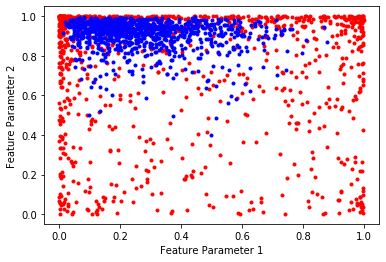

In [35]:
from pydeep.base.activationfunction import Sigmoid
import pydeep.rbm.dbn as dbn
number_of_points = 1000

uniform_points = np.random.uniform(size =(number_of_points,data_size))
# uniform_points = torch.FloatTensor(uniform_points)
normal_points = np.random.normal(loc = 0.5,size =(number_of_points,data_size))
# normal_points = torch.FloatTensor(normal_points)

normal_feature1 = np.zeros(number_of_points)
normal_feature2 = np.zeros(number_of_points)

uniform_feature1 = np.zeros(number_of_points)
uniform_feature2 = np.zeros(number_of_points)

# print(type(uniform_points))

for i in range(number_of_points):

    uniform_feature = Sigmoid.f(numx.dot(rbm.w.T,uniform_points[i])+ rbm.bv.T)   
    normal_feature =  Sigmoid.f(numx.dot(rbm.w.T,normal_points[i]) + rbm.bv.T)
    
###    uniform_feature = dbn.forward_propagate(uniform_points[i], sample=False)
###    normal_feature = dbn.forward_propagate(normal_points[i], sample=False)
###    uniform_feature= uniform_feature.detach().numpy()
###    normal_feature = normal_feature.detach().numpy()
#    normal_feature1[i] = normal_feature1[i].bcast(1,2)

    normal_feature1[i] = normal_feature[0,0]
    normal_feature2[i] = normal_feature[0,1]
    uniform_feature1[i] = uniform_feature[0,0]
    uniform_feature2[i] = uniform_feature[0,1]
    
plt.figure()
plt.xlabel('Feature Parameter 1')
plt.ylabel('Feature Parameter 2')
plt.plot(normal_feature1,normal_feature2,'r.')
plt.plot(uniform_feature1,uniform_feature2,'b.')
plt.show()

##print(np.size(uniform_feature))

In [36]:
print("shape(rbm.w.T) = ", np.shape(rbm.w.T))
print("shape(rbm.bv) = " , np.shape(rbm.bv))
uniform_points[0].reshape(1,100)
print("shape(uniform_points[0]) = " ,np.shape(uniform_points[0]))
a = Sigmoid.f(numx.dot(rbm.w.T,uniform_points[i])+ rbm.bv.T)
print('shape(a)=', np.shape(a))

shape(rbm.w.T) =  (2, 100)
shape(rbm.bv) =  (1, 100)
shape(uniform_points[0]) =  (100,)
shape(a)= (100, 2)


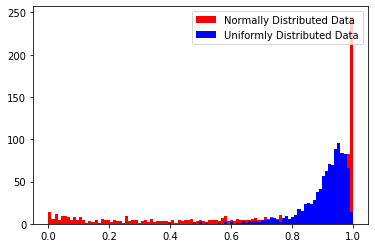

In [37]:
plt.figure()
bins = np.linspace(0, 1, 100)
plt.hist(normal_feature2,bins,color = 'red',label = 'Normally Distributed Data')
plt.hist(uniform_feature2,bins,color = 'blue', label = 'Uniformly Distributed Data')
plt.legend(loc='upper right')
plt.show() #make the bar sizes the same!